## Treatment T20

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import imblearn


TREATMENT = "t20a"

export_folder = f"../data/output/diagrams/{TREATMENT}"
os.makedirs(export_folder, exist_ok=True)

# Read and sanitize the data
df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
# drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [8]:
df_full[["ai_offer", "min_offer"]].describe()

,ai_offer,min_offer
count,105.0,105.000000
mean,50.0,41.333333
std,0.0,22.884184
min,50.0,0.000000
25%,50.0,25.000000
50%,50.0,45.000000
75%,50.0,50.000000
max,50.0,100.000000


**Correlation to the target value**

**Responder's min_offer / Proposer's over and final_offer distribution**

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


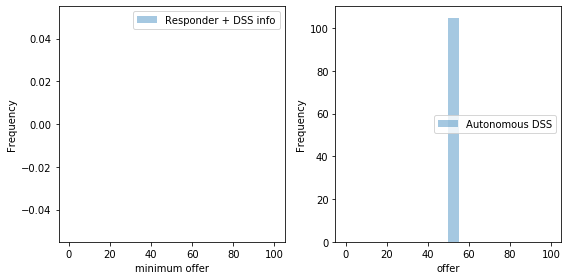

In [14]:

bins = list(range(0, 105, 5))
f, axes = plt.subplots(1, 2, figsize=(8,4))
# ax = sns.distplot(df["min_offer_final"], hist=True, kde=False, axlabel="Responder minimum offer", bins=bins, label="Responder", ax=axes[0])
ax = sns.distplot(df["min_offer_final"], hist=True, kde=False, axlabel="minimum offer", bins=bins, label="Responder + DSS info", ax=axes[0])
_ = ax.set_ylabel("Frequency")
ax.legend(loc='best')

ax = sns.distplot(df_full["ai_offer"], hist=True, kde=False, axlabel="offer", bins=bins, label="Autonomous DSS", ax=axes[1])
_ = ax.set_ylabel("Frequency")
ax.legend(loc='center right')
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.pdf"))

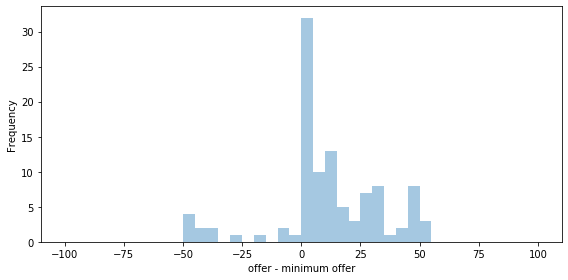

In [15]:
bins = list(range(-100, 105, 5))

plt.figure(figsize=(8,4))
offer_min_offer_diff = df_full["ai_offer"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Responder")
_ = ax.set_ylabel("Frequency")


# offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer_final"]
# ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Responder + DSS info", ax=ax)
# plt.legend()
plt.tight_layout()
ax.figure.savefig(os.path.join(export_folder, "offer-min_offer.pdf"))

In [5]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain_mean, rejection_ratio, loss_sum, MAX_GAIN

def get_infos(min_offer, offer, metrics=None, do_cross_compute=False):
    if metrics is None:
        metrics = [avg_gain_ratio, gain_mean, rejection_ratio, loss_sum]
    #df = pd.DataFrame()
    infos = dict()
    for idx, metric in enumerate(metrics):
        if do_cross_compute:
            infos[metric.__name__] = cross_compute(min_offer, offer, metric)
        else:
            infos[metric.__name__] = metric(min_offer, offer)

    return infos

**Proposer's performance**

In [6]:
df_infos = pd.DataFrame()
#Human (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['ai_offer']), ignore_index=True)
#Human (cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer'], do_cross_compute=True), ignore_index=True)
#Human + DSS (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final']), ignore_index=True)
#Human + DSS(cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final'], do_cross_compute=True), ignore_index=True)
#Top-model (fixed 50% prediction) average performance t00
fixed_offer = MAX_GAIN // 2
df_infos = df_infos.append(get_infos(df_full['min_offer'], [fixed_offer], do_cross_compute=True), ignore_index=True)

df_infos.index = ["Proposer", "Proposer (cross matched)", "Proposer + DSS", "Proposer + DSS (cross matched)", "AI-System"]

df_infos = df_infos.loc[["Proposer", "Proposer + DSS", "AI-System"]]
df_infos


,avg_gain_ratio,gain_mean,loss_sum,rejection_ratio
Proposer,0.552616,34.857143,2500.0,0.323810
Proposer + DSS,0.603521,37.523810,2220.0,0.247619
AI-System,0.714189,43.809524,1560.0,0.123810


In [7]:
def woa(offer_final, offer, ai_offer):
    res = (abs(offer_final - offer) ) / (abs(ai_offer - offer ))
    res = res[np.invert(np.isnan(res) | np.isinf(res))]
    res = np.clip(res, 0, 1)
    return abs(res).mean()

def get_resp_variation(df_full):
    df_full = df_full.copy()[df_full["min_offer"]>0]
    return 100 * ((df_full["min_offer"] - df_full["min_offer_dss"]) / df_full["min_offer"]).mean()

def get_rel_gain(df_infos):
    acc = df_infos['avg_gain_ratio']['Proposer']
    acc_dss = df_infos['avg_gain_ratio']['Proposer + DSS']
    return 100 * abs(acc - acc_dss) / acc

def get_dss_usage(df_full):
    return 100 * (df_full.ai_nb_calls > 0).mean()

print("rel_gain: ", round(get_rel_gain(df_infos), 2), "%")
print("dss_usage: ", round(get_dss_usage(df_full), 2), "%")    
print("rel_min_offer_variation: ", round(get_resp_variation(df_full), 2), "%")

rel_gain:  9.21 %
dss_usage:  0.0 %
rel_min_offer_variation:  0.0 %
